<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports

In [237]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')


In [238]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 3000;

<IPython.core.display.Javascript object>

In [239]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [240]:
#constants
DF_PATH1 = "temp/df1.csv"
DF_PATH2 = "temp/df2.csv"

In [241]:
droping = ["RegAddress.County", "DissolutionDate"]
df1 = pd.read_csv(DF_PATH1)
df2 = pd.read_csv(DF_PATH2)
df1.drop(columns=droping, inplace=True, axis=1)
#df2.drop(columns=droping, inplace=True, axis=1)
#df1 = df1[(df1["ProfitLoss.yr1"] < 2000000) & (df1["ProfitLoss.yr1"] > -2000000)]

def parse_claim_GWP(y):
    y.rename("Claim/Cost ratio", inplace=True)
    #y = np.nan_to_num(y)
    y.fillna(0, inplace=True)
    y.replace([np.inf, -np.inf], [+ 10, -10], inplace=True)
    y.replace(-1.333000e+06, -20, inplace=True)
    return y
y_ratio = df1["Claims"] / df1["GWP"]
y_ratio = parse_claim_GWP(y_ratio)
y_ratio_bool = df1["Claims"] > df1["GWP"]* 0.5

y_ratio_bool = parse_claim_GWP(y_ratio_bool) #remove NaN and inf
y_claim = df1["Claims"] > 0


# Functions

In [256]:
def remove_zero_values(x_values, y_values, remove_zero):
    df = pd.concat((x_values, y_values), axis=1)
    df.fillna(10, inplace=True)
    df = df[y_values != 10]
    if remove_zero:
        df = df.loc[(df!=0).any(1)]
        df = df[(x_values != 0)]
        df = df[y_values != 0]
        
    x_values = df[x_values.name]
    y_values = df[y_values.name]
    return x_values, y_values
    
def plot_scatter_density(x_values, y_values, xmax=None, ymax=None, xmin=None, ymin=None):
    sns.set()
    plt.xlabel(x_values.name)
    plt.ylabel(y_values.name)
    plt.ylim(ymax=ymax, ymin=ymin)
    plt.xlim(xmax=xmax, xmin=xmin)
    
    
    x_values, y_values = remove_zero_values(x_values, y_values)
    
    xy = np.vstack([x_values,y_values])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots()
    
    ax.scatter(x_values, y_values, c=z, s=100, edgecolor='')
    plt.rcParams["figure.figsize"] = [12, 6]

    plt.show() 
    
def plot_hist(data):
    sns.set()  # use seaborn package for design
    _ = plt.hist(data, bins=10)

    plt.ylabel("Frequency")
    plt.xlabel(data.name)
    plt.show()
    

#df1.columns

def plot_scatter(x_values, y_values, xmax=None, ymax=None, xmin=None, ymin=None, trendline=False, remove_zero=True):
    sns.set()
    
    plt.xlabel(x_values.name)
    plt.ylabel(y_values.name)
    if ymax or ymin:
        plt.ylim(ymax=ymax, ymin=ymin)
    if xmax or xmin:
        plt.xlim(xmax=xmax, xmin=xmin)
    plt.rcParams["figure.figsize"] = [12, 6]
    
    #plt.yscale('log')
    #plt.xscale('log')
    
    x_values, y_values = remove_zero_values(x_values, y_values, remove_zero)
    plt.scatter(x_values, y_values, marker=".")
    
    

    if trendline:
        # calc the trendline
        slope, intercept, r_value, p_value, std_err = linregress(x_values,y_values)
        print("y={:.6f}x + {:.6f}".format(slope, intercept))
        print("P Value: {:.3f}".format(p_value))
        z= np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        pylab.plot(x_values,p(x_values),"r--")
        # the line equation:
        #print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

    plt.show()
    
def profile_companies(df, remove_zeros=True):
    y_ratio = df["Claims"] / df["GWP"]
    y_ratio = parse_claim_GWP(y_ratio)
    for column in df.columns:
        try:
            if "Date" not in column:
                if "SICCode" not in column:
                    plot_scatter(df[column], y_ratio, remove_zero=remove_zeros, trendline=True)
        #except IndexError:
        except (TypeError, ValueError, IndexError):
            print("could not print", column)
            


In [254]:
def display_multiple_bar_charts(columns, df, check_low_freq=False, extreme_only=False, freq_cutoff=20, \
                                extreme_ratio=0.35, x_label=None):
    
    
    length = len(columns) // 3 + 1
    #     print("Length:", length)
    #     print("Total allowed:", length * 3)
    #     print("Total number:", len(columns))
    fig = plt.figure(figsize=(20, length*4))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    position = 1
    
    CLAIM_1 = 27.80
    RATIO_1 = 13.42
    extr = {"extreme_claim_h": (1 + extreme_ratio) * CLAIM_1,
           "extreme_claim_l": (1 - extreme_ratio) * CLAIM_1,
           "extreme_ratio_h": (1 + extreme_ratio) * RATIO_1,
           "extreme_ratio_l": (1 - extreme_ratio) * RATIO_1,}
    X_LABEL = x_label
    for i in range(1, len(columns) + 1):
        
        column = columns[i - 1]
        
        temp = df[df[column] == 1] #selected values of df
        ys = {"Claim": temp["Claims"] > 0, "Ratio": (temp["Claims"] / temp["GWP"] > 0.5)}
        
        data = {}
        percentages = {}
        count = 0
        key_dict = {}
        for key, y in ys.items():
            total = 0
            try:
                false_count = y.value_counts()[0]
            except (KeyError,IndexError):
                false_count = 0
            try:
                true_count = y.value_counts()[1]
            except (KeyError,IndexError):
                true_count = 0
            data[key + "_0"] = false_count
            data[key + "_1"] = true_count
            total = false_count + true_count
            if false_count == 0 and true_count == 0:
                percentages[key + "_0"] = 0
                percentages[key + "_1"] = 0
            else:
                percentages[key + "_0"] = round((false_count/total)*100, 2)
                percentages[key + "_1"] = round((true_count/total)*100, 2)
            key_dict[count] = key + "_0"
            key_dict[count + 1] = key + "_1"
            count += 2
        if check_low_freq:
            total = 0
            for key, val in data.items():
                total += val
            if total < freq_cutoff:
                continue
        
        if extreme_only:
            if (percentages["Claim_1"] <= extr["extreme_claim_h"] and percentages["Claim_1"] >= extr["extreme_claim_l"]) and \
                (percentages["Ratio_1"] <= extr["extreme_ratio_h"] and percentages["Ratio_1"] >= extr["extreme_ratio_l"]):
                continue

        data = pd.Series(data)
        ax = fig.add_subplot(length, 3, position)
        ax.bar(data.index, data, color= ["#3399ff", "#ba2424"]* 2)
        x_label = X_LABEL
        if not x_label:
            x_label = column
        ax.set_xlabel(x_label, wrap=True)
        ax.set_ylabel("Frequency")
        
        # set individual bar lables
        for index, patch in enumerate(ax.patches):
            key = key_dict[index]
            ax.text(patch.get_x() + 0.1, 1, \
                        str(percentages[key])+'%', fontsize=12, color='black')
        position += 1
        
        """print(true_count, false_count)
        print(total, false_val.get_height() + true_val.get_height())
        print(false_val)
        print(true_val)
        print()"""
        

In [244]:
def get_col_names_containing(variables_list, df):
    columns_final = []
    for variable in variables_list:
        min_samples_splits = [2**x for x in range(1,4)]
        columns_final.extend([x for x in df.keys() if variable in x])
    return columns_final

In [245]:
def describe_(df):
    y_ratio = df["Claims"] / df["GWP"]
    y_ratio = parse_claim_GWP(y_ratio)
    df_bad = df[y_ratio > 0.5]
    df_good = df[y_ratio  < 0.5]
    return df_good.describe().subtract(df_bad.describe())

# Preprocessing

In [246]:
DF_PATH1 = "temp/df1.csv"
DF_PATH2 = "temp/df2.csv"

In [247]:
droping = ["RegAddress.County", "DissolutionDate"]
df1 = pd.read_csv(DF_PATH1)
df2 = pd.read_csv(DF_PATH2)
df1.drop(columns=droping, inplace=True, axis=1)
#df2.drop(columns=droping, inplace=True, axis=1)
#df1 = df1[(df1["ProfitLoss.yr1"] < 2000000) & (df1["ProfitLoss.yr1"] > -2000000)]

def parse_claim_GWP(y):
    y.rename("Claim/Cost ratio", inplace=True)
    #y = np.nan_to_num(y)
    y.fillna(0, inplace=True)
    y.replace([np.inf, -np.inf], [+ 10, -10], inplace=True)
    y.replace(-1.333000e+06, -20, inplace=True)
    return y
y_ratio = df1["Claims"] / df1["GWP"]
y_ratio = parse_claim_GWP(y_ratio)
y_ratio_bool = df1["Claims"] > df1["GWP"]* 0.5

y_ratio_bool = parse_claim_GWP(y_ratio_bool) #remove NaN and inf
y_claim = df1["Claims"] > 0


In [248]:
df_micro = df1[(df1["AverageNumberEmployeesDuringPeriod.yr0"] < 10)]
df_small = df1[(df1["AverageNumberEmployeesDuringPeriod.yr0"] < 50) & (df1["AverageNumberEmployeesDuringPeriod.yr0"] >= 10)]
df_medium = df1[(df1["AverageNumberEmployeesDuringPeriod.yr0"] >= 50) & (df1["AverageNumberEmployeesDuringPeriod.yr0"] < 250)]
df_large = df1[(df1["AverageNumberEmployeesDuringPeriod.yr0"] > 250)]

df2["Micro"] = df1["AverageNumberEmployeesDuringPeriod.yr0"] < 10
df2["Small"] = (df1["AverageNumberEmployeesDuringPeriod.yr0"] < 50) & (df1["AverageNumberEmployeesDuringPeriod.yr0"] >= 10)
df2["Medium"] = (df1["AverageNumberEmployeesDuringPeriod.yr0"] >= 50) & (df1["AverageNumberEmployeesDuringPeriod.yr0"] < 250)
df2["Large"] = (df1["AverageNumberEmployeesDuringPeriod.yr0"] > 250)

df_large.describe()
pd.set_option('display.max_columns', 500)
company_dfs = [df_micro, df_small, df_medium, df_large]

In [249]:
mapper = {}
for column in get_col_names_containing(["(-0.1, 0.1]"], df2):
    new = column.replace("(-0.1, 0.1]", "NaN")
    mapper[column] = new
df2.rename(mapper, axis=1, inplace=True)

In [250]:
columns = get_col_names_containing(["CompanyCategory"], df2)
mapper = {"CompanyCategory_Private Limited Company": "CompanyCategory_PLC",
            "CompanyCategory_PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)": "CompanyCategory_PRI/LTD BY GUAR/NSC",
            "CompanyCategory_PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)": "CompanyCategory_PRI/LBG/NSC"}
df2.rename(mapper=mapper, axis=1, inplace=True)

# Analysis

## General Results  
The more a company spends on their policy, the more likely they are to claim.  
However, the more expensive policies are more profitable for QBE than the cheaper ones:   
RATIO = (Total Claims paid out, "Claims") / (Money spent on policy, "GWP")


y=0.308481x + 926.262766
P Value: 0.000


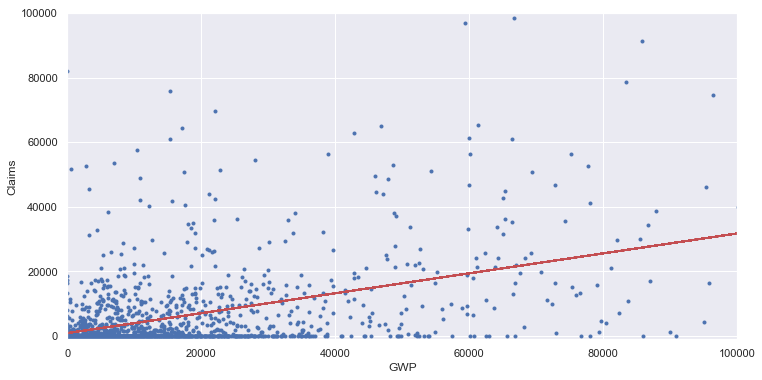

In [257]:
plot_scatter(df1["GWP"], df1["Claims"], xmax=100000, xmin=0, ymax=100000, ymin=-1000, trendline=True, remove_zero=False)

y=-0.000007x + 1.478552
P Value: 0.052


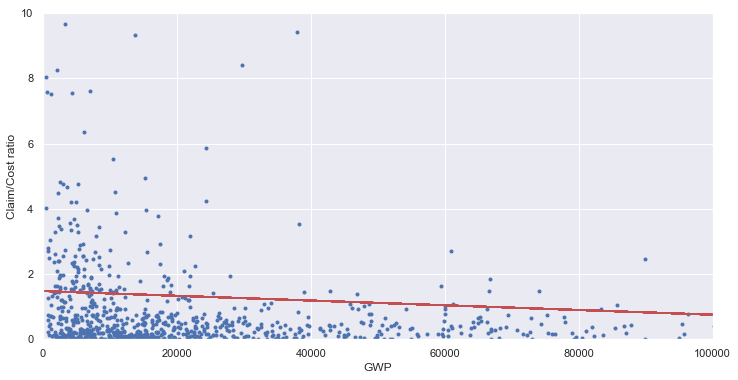

In [206]:
plot_scatter(df1["GWP"], y_ratio, xmax=100000, xmin=0, ymax=10, ymin=0, trendline=True)

## Percentages of claim


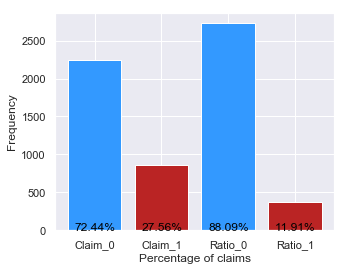

In [207]:
columns = get_col_names_containing(["CountryOfOrigin"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = False, x_label="Percentage of claims")

<b>Claim_0</b> - No claim  
<b>Claim_1</b> - Claim  
<b>Ratio_0</b> - RATIO < 0.5  
<b>Ratio_1</b> - RATIO > 0.5  

## !! Note !!:  
Due to difficulty of full-scale prediction, I've attempted to indentify flags for high or low claim probability.  
Therefore all (most) succeeding versions of above graph are extreme values.  
"Extreme values" are those graphs with values of (Claim_0, Claim_1 etc) that are larger or smaller than the mean by a notable amount - 35% by default.  

Graphs with low sample-size are also ommitted.

## Insurance Portfolio
There is a massive variation in QBE's Portfolio profitability.  
They are almost certainly already aware of this but it's very striking.

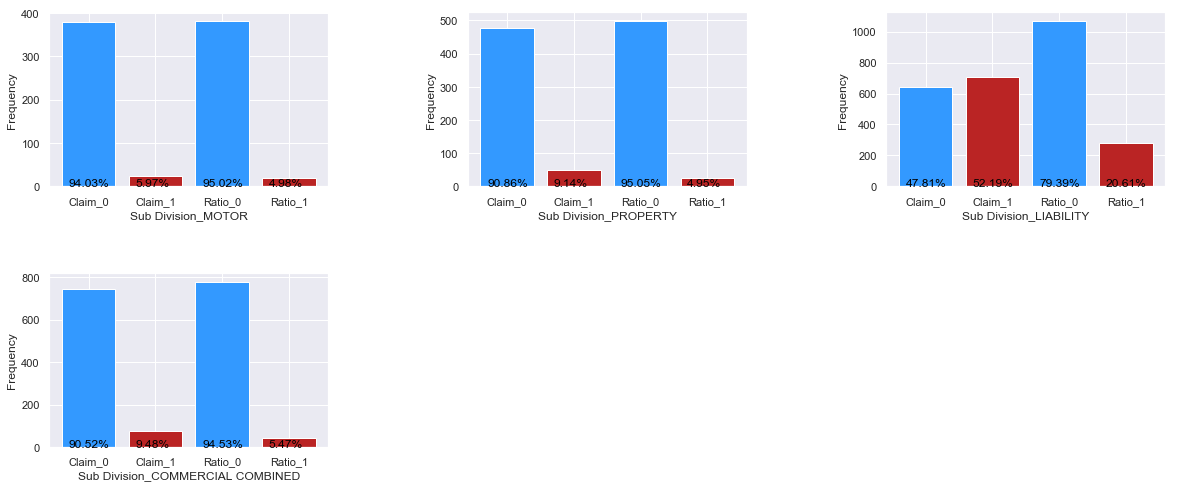

In [208]:
columns = get_col_names_containing(["Sub Division"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True)

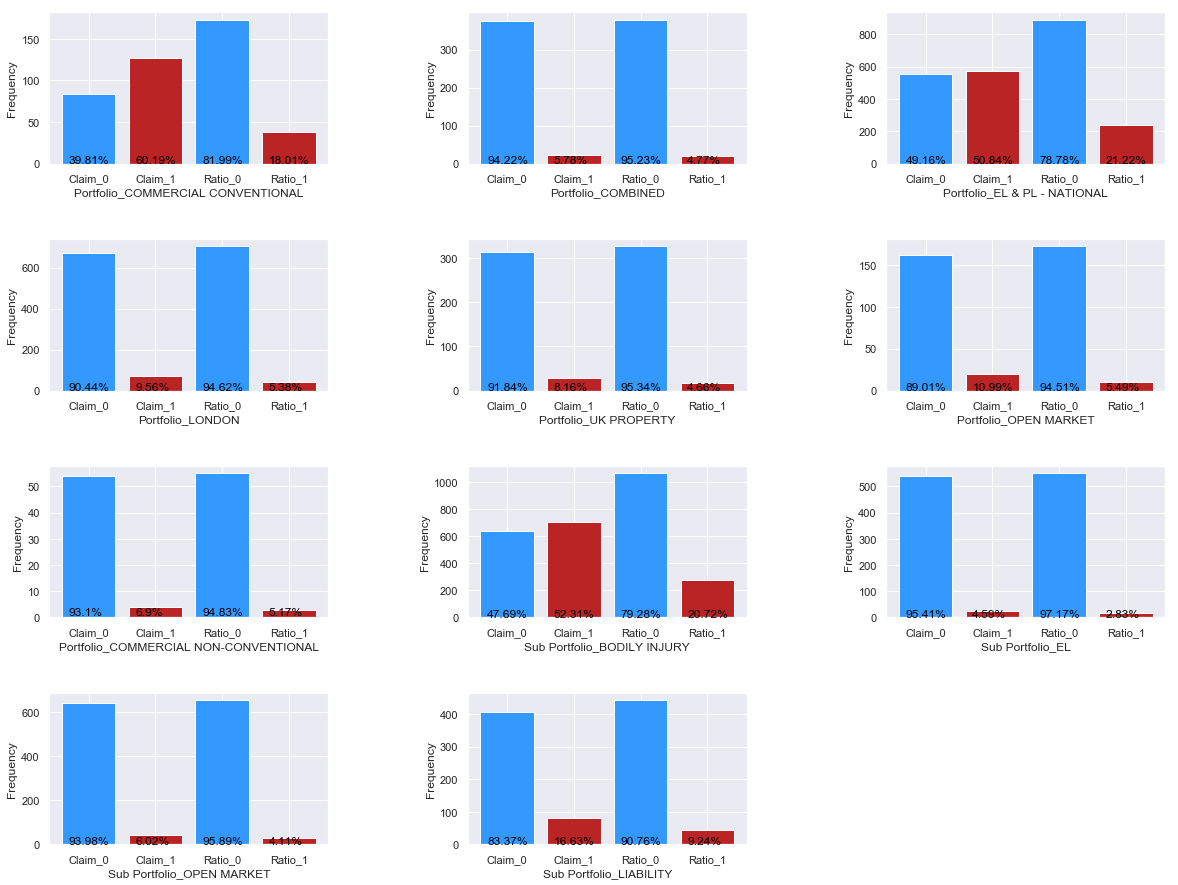

In [209]:
columns = get_col_names_containing(["Portfolio"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True)

## Company Size
Generally speaking, "Small" and "Medium" sized companies (10 - 250 employees) have a higher likelyhood of claiming than "Micro" companies (< 10 employees). 

FINDING: v. small and young companies (Micro) are less likely to have high RATIO.
FINDING: Companies w. 10-250 employees are most likely to have high RATIO.  
FINDING(?): Above 250 employees, companies have lower RATIO. Small sample for this group but this is bourne out by general trends too. 

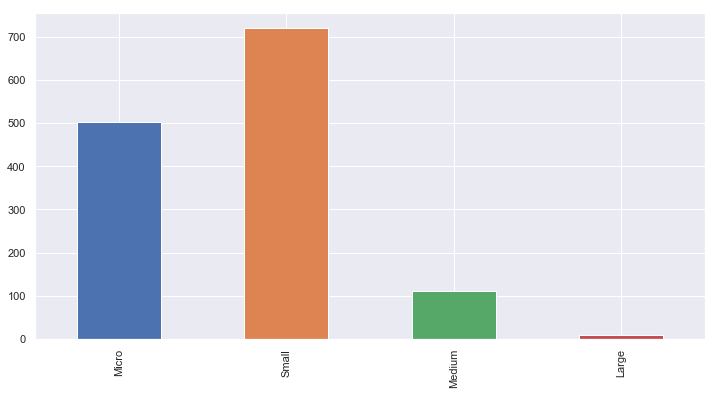

In [233]:
series = pd.Series({"Micro": len(df_micro), "Small": len(df_small), "Medium": len(df_medium), "Large": len(df_large)})
series.plot(kind='bar')

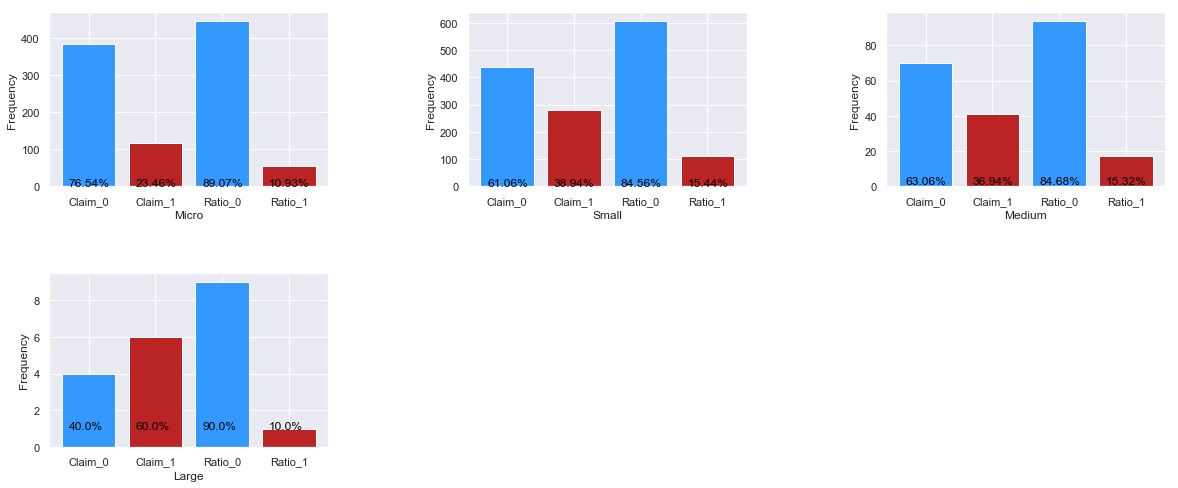

In [211]:
columns = get_col_names_containing(["Micro", "Small", "Medium", "Large"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff=20, extreme_only=False)

### Larger company, larger RATIO

y=0.000288x + 1.044156
P Value: 0.063


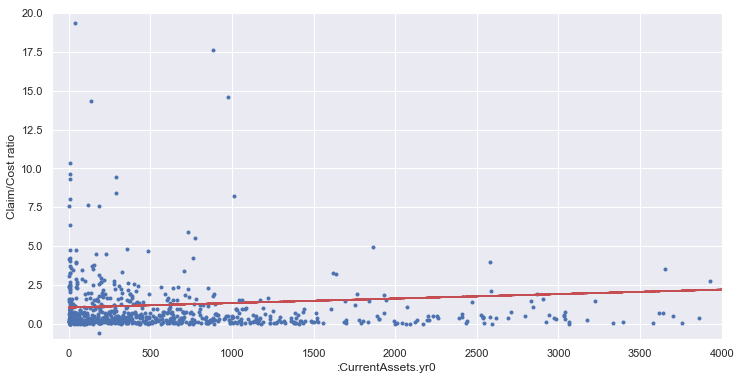

y=0.000321x + 1.226728
P Value: 0.127


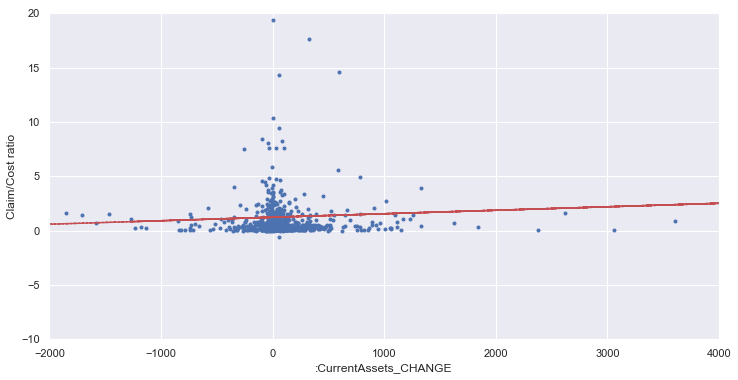

In [212]:
y_ratio = df1["Claims"] / df1["GWP"]
y_ratio = parse_claim_GWP(y_ratio)
plot_scatter(df1[':CurrentAssets.yr0']/1000, y_ratio, xmax=4000, xmin=-100, ymax=20, ymin=-1, trendline=True)
plot_scatter(df1[':CurrentAssets_CHANGE']/1000, y_ratio, xmin = -2000, xmax=4000, ymax=20, ymin= -10, trendline=True)

## Region
FINDING: West Midlands and Easy Midlands appears to have lower claims than national average. South East has more.  

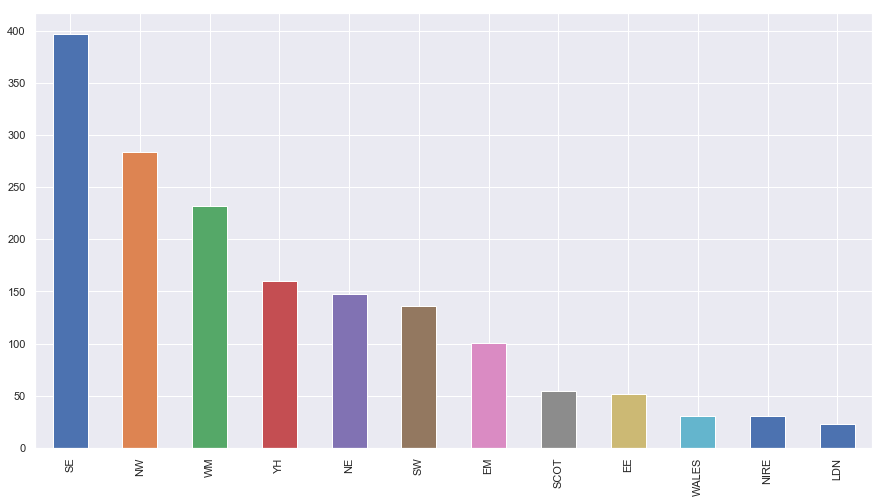

In [213]:
df1['Region'].value_counts().plot(kind='bar', figsize=(15,8))

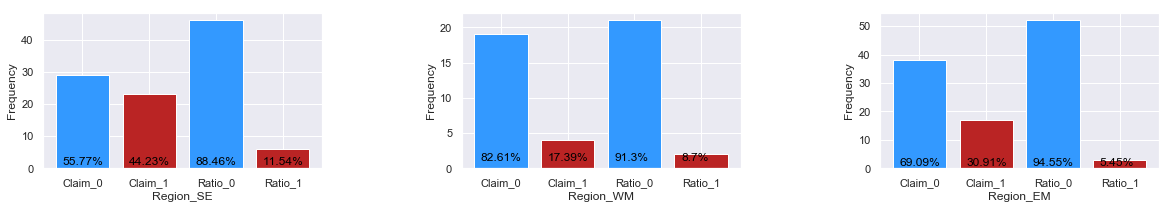

In [214]:
columns = get_col_names_containing(["Region"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = False, extreme_only=True)

## Industry
Similarly, there are numerous Industries (and Sic codes) of interest.  
FINDING: the more industries (or SIC Codes) a company declares, the more likely they are to make a claim.

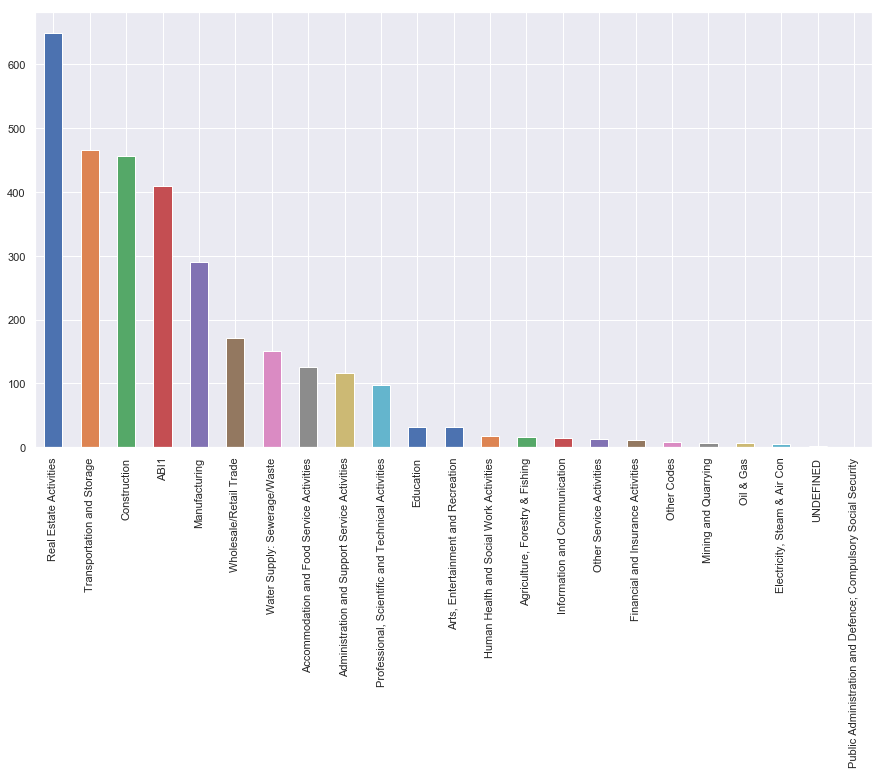

In [215]:
df1['Industry Section'].value_counts().plot(kind='bar',figsize=(15, 8))

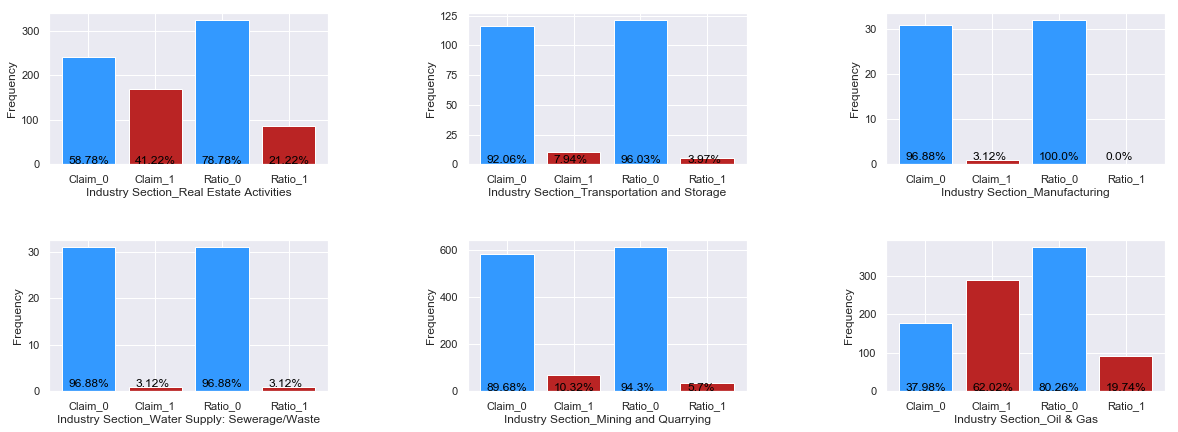

In [216]:
columns = get_col_names_containing(["Industry Section"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff=35, extreme_only=True, extreme_ratio = .45)

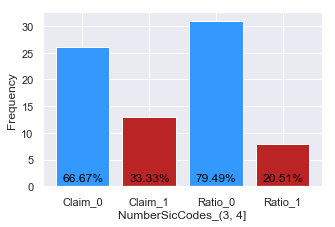

In [217]:
columns = get_col_names_containing(["NumberSicCodes"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = False, freq_cutoff = 20, extreme_only=True, extreme_ratio = .30)

y=0.473216x + -0.206117
P Value: 0.000


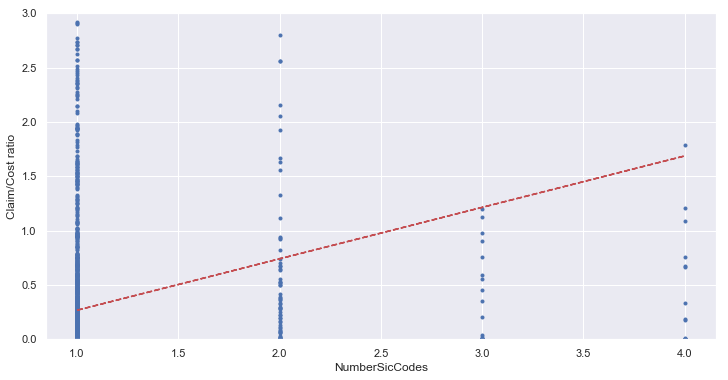

In [218]:
y_ratio = df1["Claims"] / df1["GWP"]
y_ratio = parse_claim_GWP(y_ratio)
plot_scatter(df1['NumberSicCodes'], y_ratio, trendline=True, remove_zero=False, ymax = 3)

### Relevant Sic codes

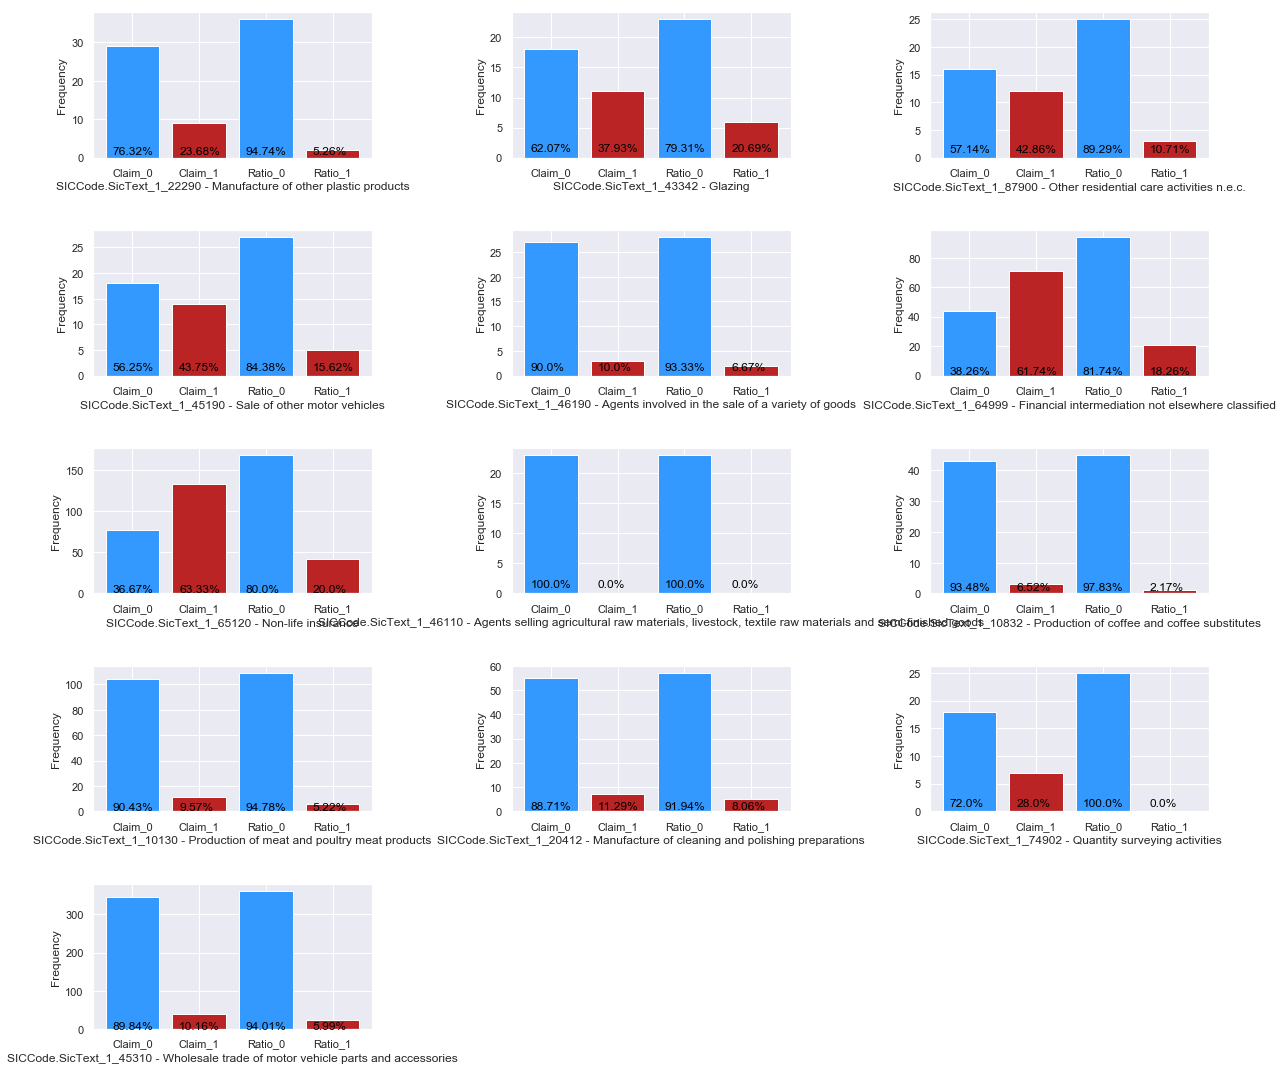

In [219]:
columns = get_col_names_containing(["SICCode"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 45, extreme_only=True, extreme_ratio=.50)


## Basic Company Info

The following type of company is considerably less likely to claim:  
"CompanyCategory_PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)"  
  
FINDING: Dormant companies and those that submit unaudited accounts are less likely to claim whilst those that are part of a group are much more likely to have large RATIO.

FINDING: If a company has multiple mortgages, they are less likely to claim.

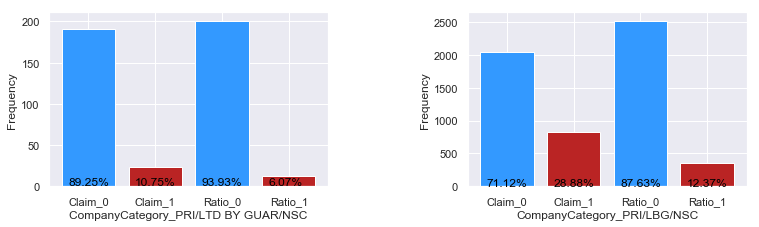

In [220]:
columns = get_col_names_containing(["CompanyCategory"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True)

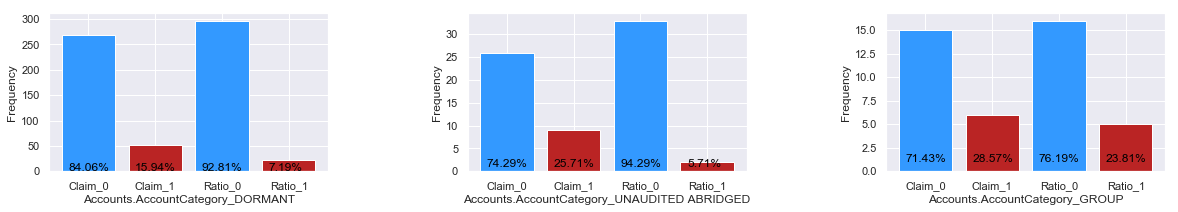

In [221]:
columns = get_col_names_containing(["Accounts.AccountCategory"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, extreme_only=True, extreme_ratio=0.4)

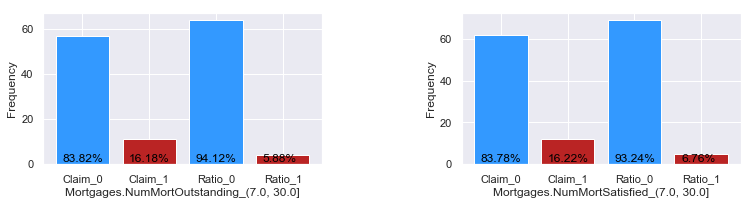

In [222]:
columns = get_col_names_containing(["Mortgages"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 35, extreme_only=True, extreme_ratio = .35)

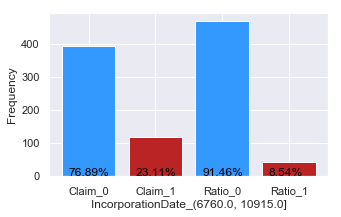

In [223]:
columns = get_col_names_containing(["IncorporationDate"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 20, extreme_only=True, extreme_ratio = .2)

## Employees and Officers

The danger area in terms of employee number is around 50 - 250. This tallies with company size findings.  
Crucially, when there is a large change in employee number, there is a large increase in likelyhood of claim.  

FINDING: As company is growing quickly it is more likely to claim  

There appears to be a relationship between the size of company and the optimum number of Employees per Officer but the dataset is too small to give solid findings here. 

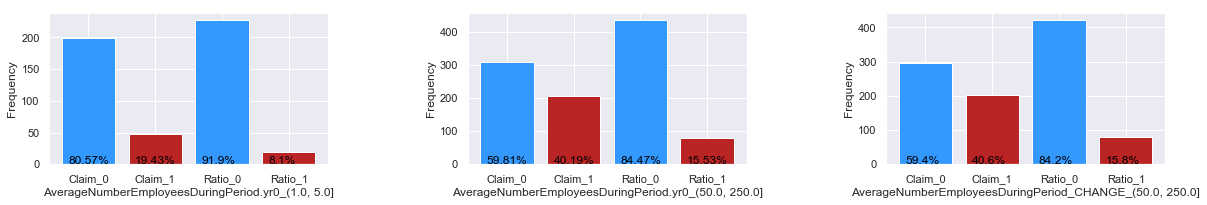

In [234]:
columns = get_col_names_containing(["AverageNumberEmployeesDuringPeriod"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .35)

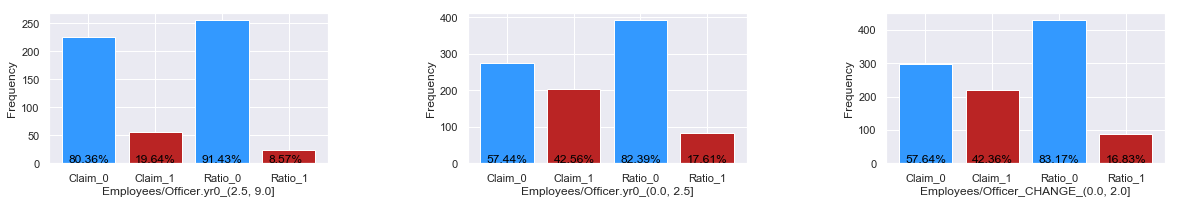

In [225]:
columns = get_col_names_containing(["Officer"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .35)

## Financial Data

There is a lot here but there are numerous insights from the financials. 

### Profit/Loss

FINDING: Large negative value of P/L makes claim LESS likely. Counterintuitively.   
FINDING: Large decrease in P/L year to year makes claim more likely. 
FINDING: If there is a no value given (i.e. NaN), there is unlikely to be a claim. Small companies are less likely to declare this information so this tallies with the above info.

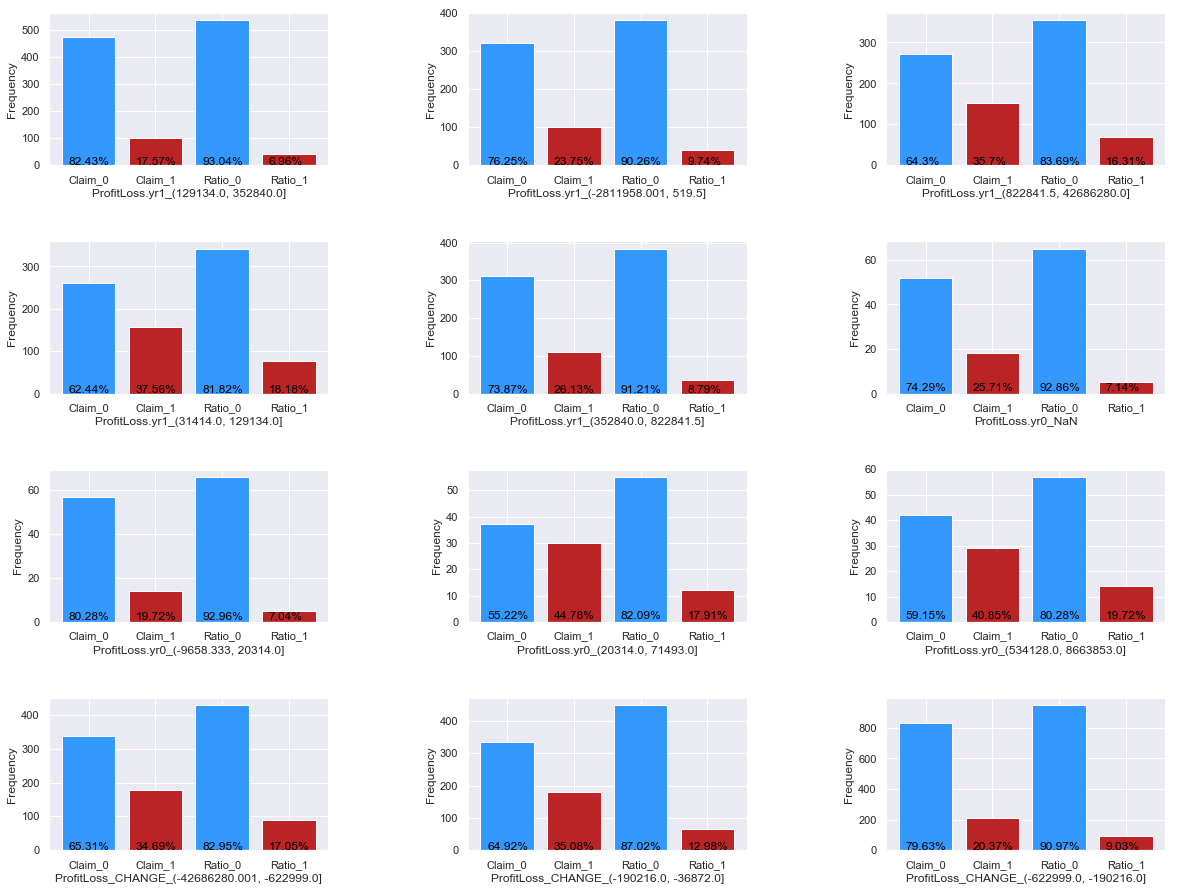

In [226]:
columns = get_col_names_containing(["ProfitLoss"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .22)

### Assets

FINDING: Small or no change in TotalAssets - low claim likelyhood. Stable companies don't claim as often.   

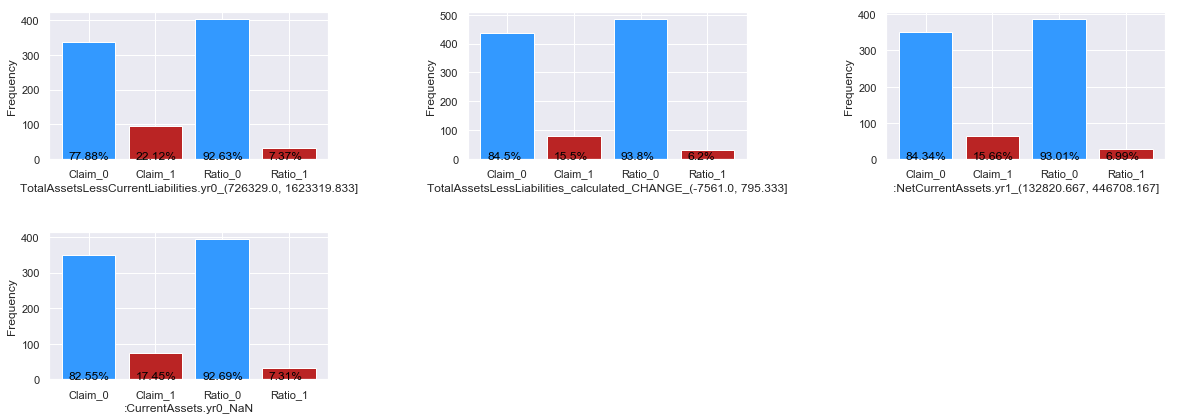

In [227]:
columns = get_col_names_containing(["TotalAssets", "CurrentAssets"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .45)

### Shareholder Funds

FINDING: If value is v. large or 0, claim likelyhood is low.  

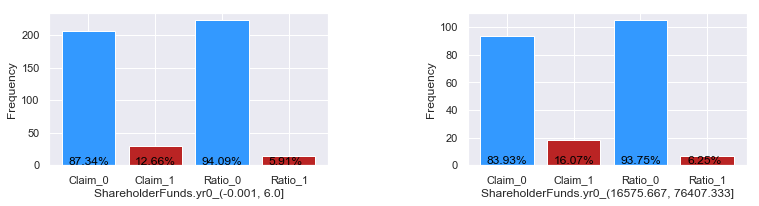

In [228]:
columns = get_col_names_containing(["ShareholderFunds"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .4)

### Liabilities

FINDING: If Borrowings is large, claim likelyhood high.  
FINDING: If Creditors is large, claim likelyhood low.  
FINDING: If liabilities decreases by large amount, claim likelyhood low.  
FINDING: If Liabilities/Assets decreases by large amount, claim likelyhood low.   

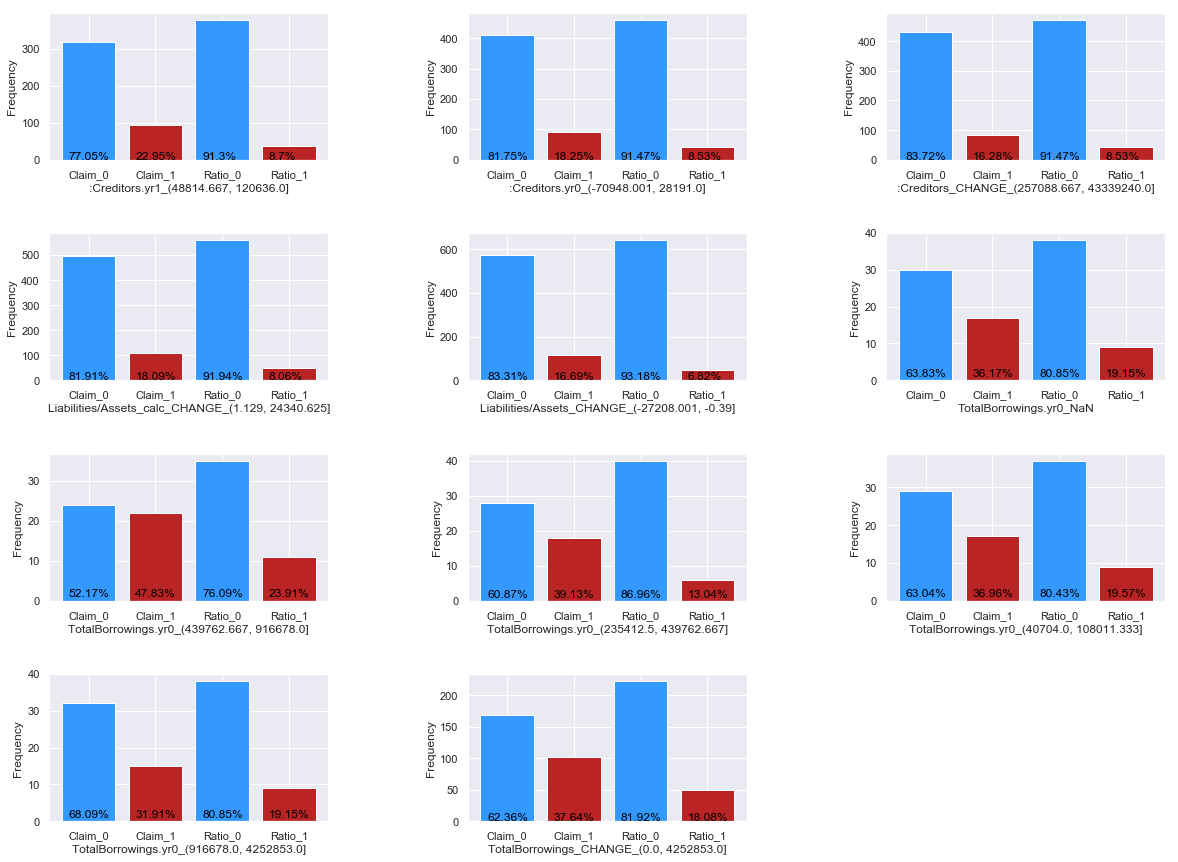

In [229]:
columns = get_col_names_containing(["Creditors", "Liabilities/Assets", "Borrowings"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .35)

### Provisions for Liabilities


FINDING: If Provisions/Assets is 0 (i.e. provisions is 0) or very high, claim likleyhood is high.  
BUT:  
FINDING: If Provisions/Assets is small but greater than zero, claim likleyhood is very low!  
Potentially, there is a penalty for keeping a large provision (Directors are either too cautious or know they have already done something wrong) but that it is unwise not to keep any.
  
  
FINDING: If Liabilities/Provisions decreases by large amount, claim likelyhood is low.  

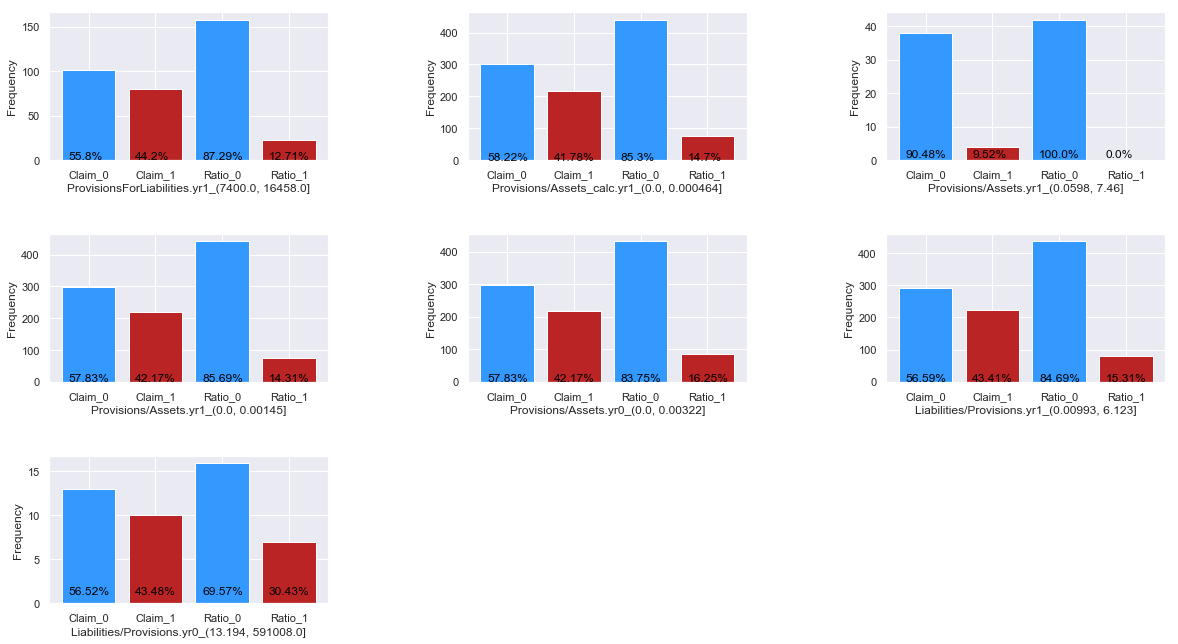

In [230]:
columns = get_col_names_containing(["Provisions"], df2)
display_multiple_bar_charts(columns, df2, check_low_freq = True, freq_cutoff = 40, extreme_only=True, extreme_ratio = .5)